# Sub-sampled hematopoietic dataset

Top 15% most heterogeneous clones of the hematopoiesis data set from *Weinreb, C., Rodriguez-Fraticelli, A., Camargo, F. D. & Klein, A. M. Science 367, (2020)*. This dataset has 3 time points for both the clones and the state measurements. 

This sub-sampled data better illustrates the power of CoSpar in robstly 
inferring differentiation dynamics from a noisy clonal dataset. Also, it 
is smaller, and much faster to analyze. 

In [1]:
import scanpy as sc
import time
import cospar as cs

In [2]:
cs.logging.print_version()
cs.settings.verbosity = 3
cs.settings.set_figure_params(
    format="png", dpi=75, fontsize=14
)  # use png to reduce file size.

cs.settings.data_path = "LARRY_sp_data"  # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path = "LARRY_sp_fig"  # A relative path to save figures. If not existed before, create a new one.

Running cospar 0.0.2 (python 3.6.12) on 2021-01-28 17:17.


## Load data

In [3]:
data_path = cs.settings.data_path
figure_path = cs.settings.figure_path
adata_orig = cs.datasets.hematopoiesis_15perct(
    data_path=data_path, figure_path=figure_path
)

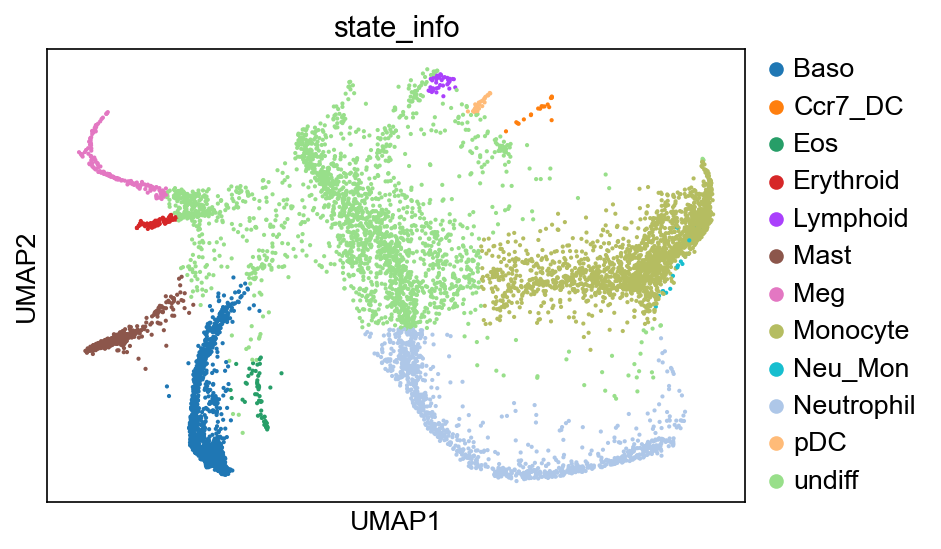

In [5]:
sc.pl.umap(adata_orig, color="state_info")

In [6]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Availabel clusters: ['pDC', 'Mast', 'Lymphoid', 'Neu_Mon', 'Monocyte', 'Neutrophil', 'Eos', 'undiff', 'Ccr7_DC', 'Erythroid', 'Baso', 'Meg']
Availabel time points: ['2', '6', '4']
Clonal time points: ['2', '6', '4']


### Raw clonal data analysis (without using state information)

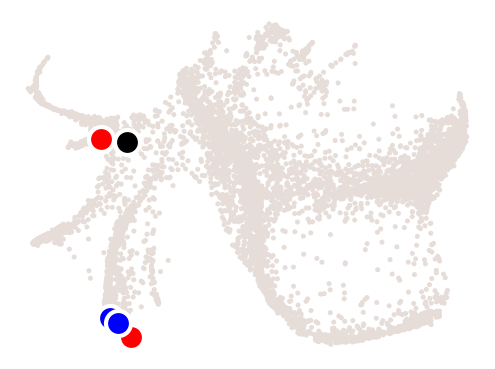

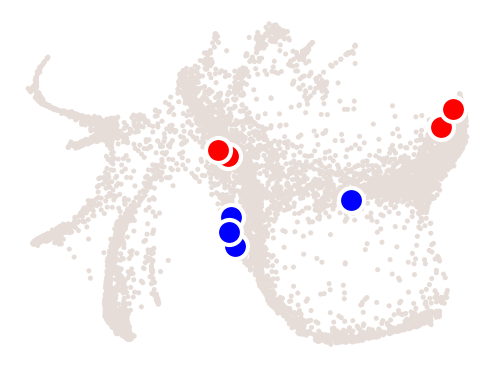

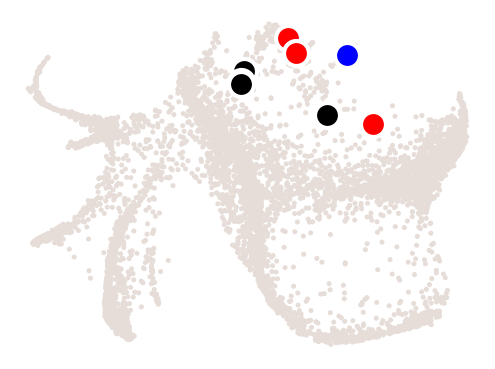

In [7]:
cs.pl.clones_on_manifold(
    adata_orig,
    selected_clone_list=[1, 2, 3],
    color_list=["black", "red", "blue"],
    point_size=2,
)

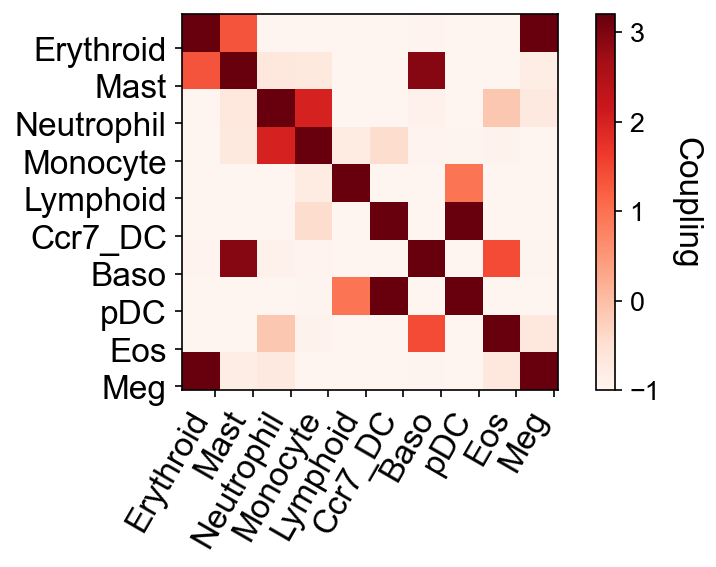

In [8]:
plot_time_point = "4"
selected_fates = [
    "Erythroid",
    "Mast",
    "Neutrophil",
    "Monocyte",
    "Lymphoid",
    "Ccr7_DC",
    "Baso",
    "pDC",
    "Eos",
    "Meg",
]
cs.pl.fate_coupling_from_clones(
    adata_orig, plot_time_point, selected_fates=selected_fates, color_bar=True
)

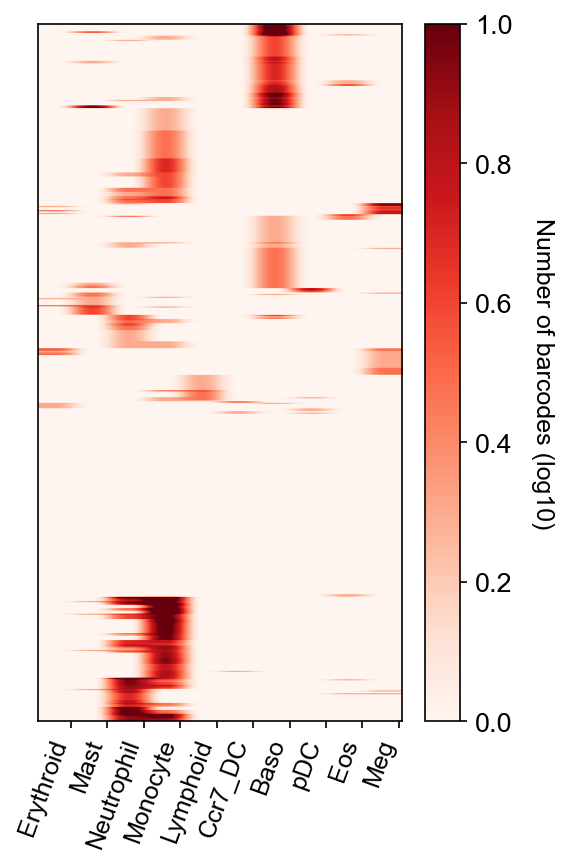

In [9]:
plot_time_point = "4"
cs.pl.barcode_heatmap(
    adata_orig, plot_time_point, selected_fates=selected_fates, color_bar=True
)

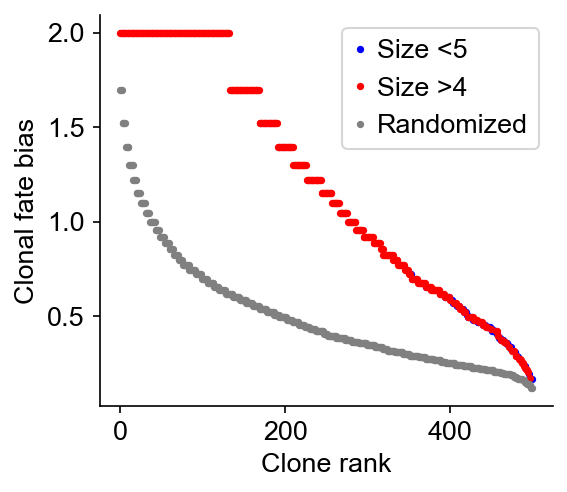

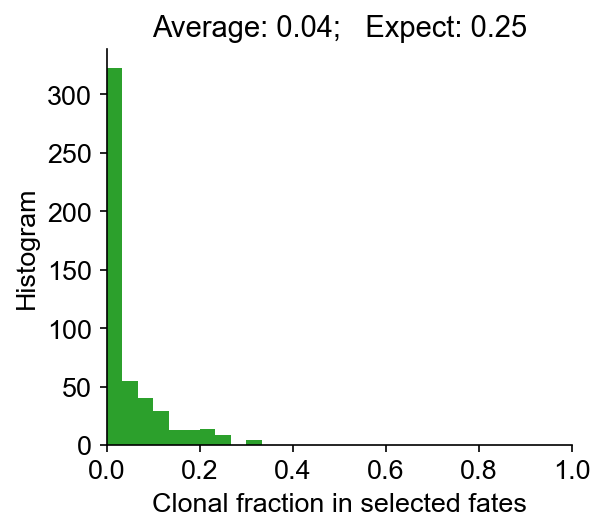

In [10]:
select_fate_cluster = "Monocyte"
clonal_fate_bias, clone_id = cs.pl.clonal_fate_bias(
    adata_orig,
    select_fate_cluster,
    clone_size_thresh=5,
    N_resampling=100,
    compute_new=False,
)

## Part 1: Infer transition map using clones from both day4 and day6

### Map inference

-------Step 1: Select time points---------
--> Clonal cell fraction (day 4-6): 1.0
--> Clonal cell fraction (day 6-4): 1.0
--> Numer of cells that are clonally related -- day 4: 3106  and day 6: 4046
Valid clone number 'FOR' post selection 500
Cell number=7152, Clone number=500
-------Step 2: Compute the full Similarity matrix if necessary---------
-------Step 3: Optimize the transition map recursively---------
---------Compute the transition map-----------
Compute similarity matrix: load existing data
--> Time elapsed:  0.11004900932312012
--> Time elapsed:  0.16320085525512695
--> Time elapsed:  0.10739922523498535
--> Time elapsed:  0.18828892707824707
Compute similarity matrix: load existing data
--> Time elapsed:  0.07364201545715332
--> Time elapsed:  0.10836410522460938
--> Time elapsed:  0.06721091270446777
--> Time elapsed:  0.12658095359802246
Compute similarity matrix: load existing data
--> Time elapsed:  0.05522894859313965
--> Time elapsed:  0.07967209815979004
--> Time e

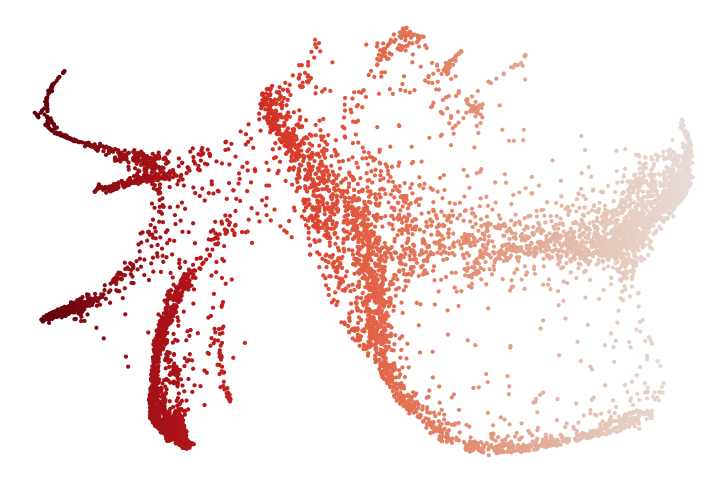

In [11]:
import time

t = time.time()
noise_threshold = 0.2  #
selected_clonal_time_points = ["4", "6"]
adata = cs.tmap.infer_Tmap_from_multitime_clones(
    adata_orig,
    selected_clonal_time_points,
    smooth_array=[20, 15, 10],
    noise_threshold=noise_threshold,
    demulti_threshold=noise_threshold,
    use_full_Smatrix=True,
)
print(f"Used--time: {time.time()-t}")

### Save or load pre-computed data

This can be used to save maps obtained from different parameter choices.
Usually, different parameter choice will result to different 'data_des', a prefix to define the map.
Saving an adata would print the 'data_des', which can be used to load the corresponding map.

In [12]:
save_data = False
if save_data:
    cs.hf.save_map(adata)

load_data = False
if load_data:
    # updated Jan 27, 2021
    data_des = "LARRY_sp500_ranking1_TwoTimeClone_t*4*6"
    # data_des='LARRY_sp500_ranking1_TwoTimeClone_t*2*4*6'
    # data_des='LARRY_sp500_ranking1_OneTimeClone_t*4*6'
    adata = cs.hf.load_saved_adata(data_des)

In [13]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'intraclone_transition_map']
Availabel clusters: ['pDC', 'Mast', 'Lymphoid', 'Neu_Mon', 'Monocyte', 'Neutrophil', 'Eos', 'undiff', 'Ccr7_DC', 'Erythroid', 'Baso', 'Meg']
Availabel time points: ['6', '4']
Clonal time points: ['6', '4']


### Plotting

There are some common parameters

* **used_map_name**: *{'transition_map', 'demultiplexed_map', 'OT_transition_map', 'HighVar_transition_map'}*
    
* **selected_fates**: selected fate clusters for things like fate map construction, DGE analysis etc. The *selected_fates* allows nested structure, e.g., *selected_fates=[['0','2'],'1']* means combined cluster '0-2' and cluster '1'
    
* **map_backwards**: *True*, assuming that the *selected_fates* are cell states belonging to later time points (t2), and map for the initial cell states; *False*, map from early states to later states.
    
* **plot_time_points**: select states at given time points for the analysis

#### Plotting transition profiles for single cells

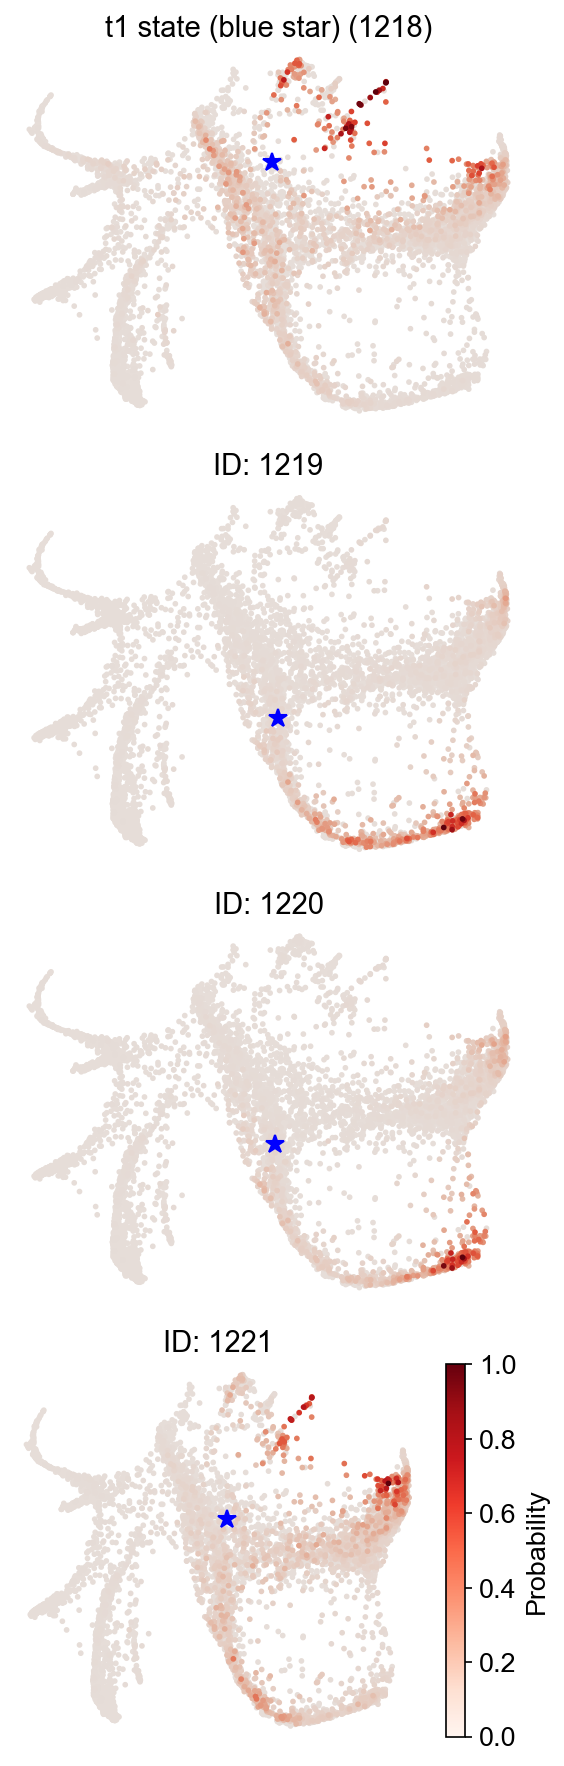

In [14]:
selected_state_id_list = [2, 3, 4, 5]

cs.pl.single_cell_transition(
    adata,
    selected_state_id_list=selected_state_id_list,
    used_map_name="transition_map",
    map_backwards=False,
)

#### Fate map

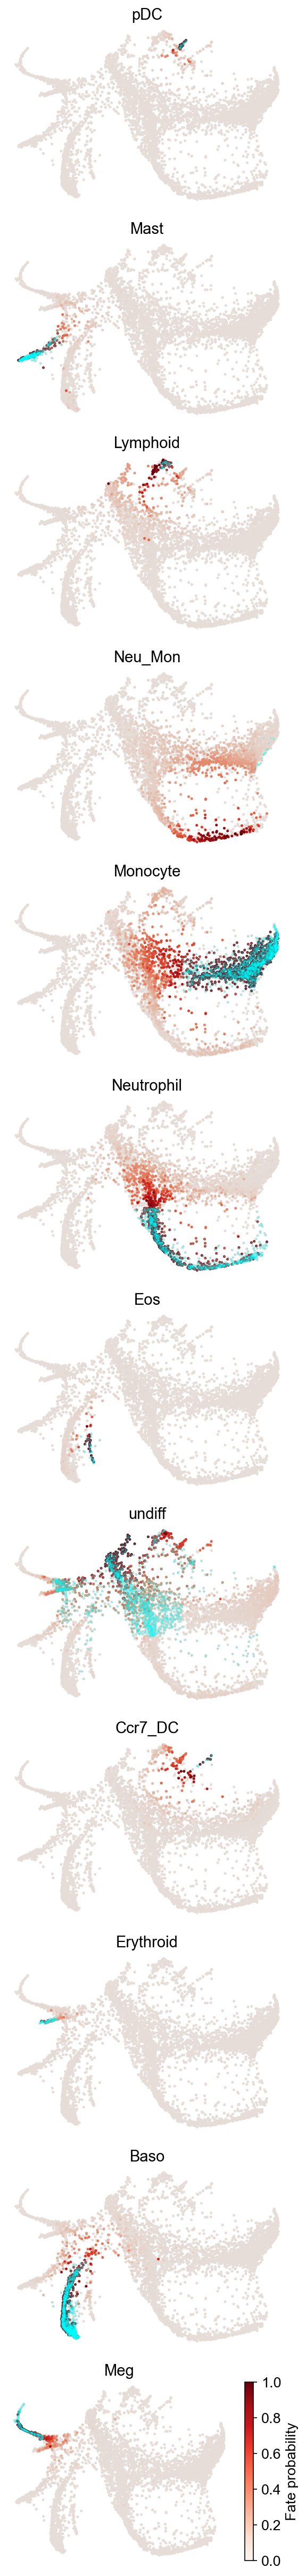

In [15]:
cs.pl.fate_map(
    adata,
    selected_fates=[],
    used_map_name="transition_map",
    map_backwards=True,
    plot_target_state=True,
)

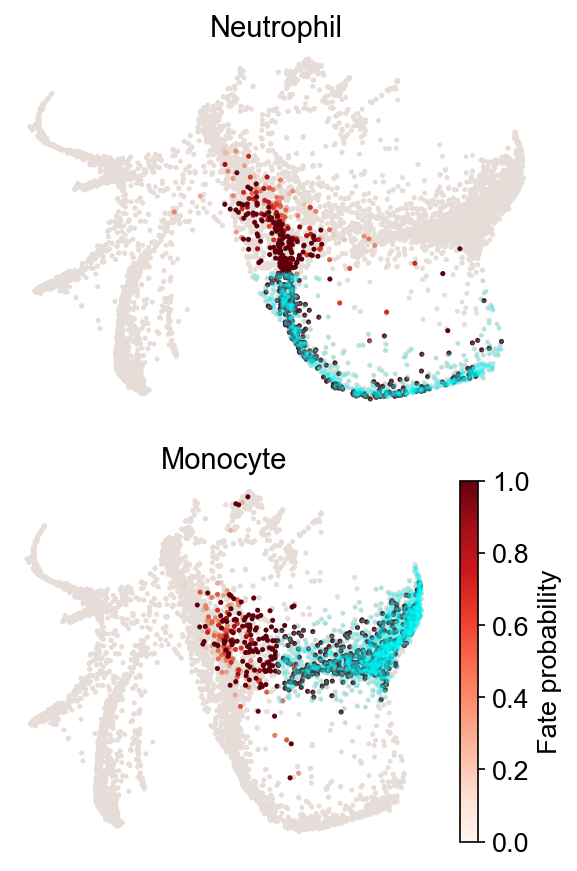

In [16]:
cs.pl.fate_map(
    adata,
    selected_fates=["Neutrophil", "Monocyte"],
    used_map_name="intraclone_transition_map",
    map_backwards=True,
    plot_target_state=True,
)

#### Fate bias

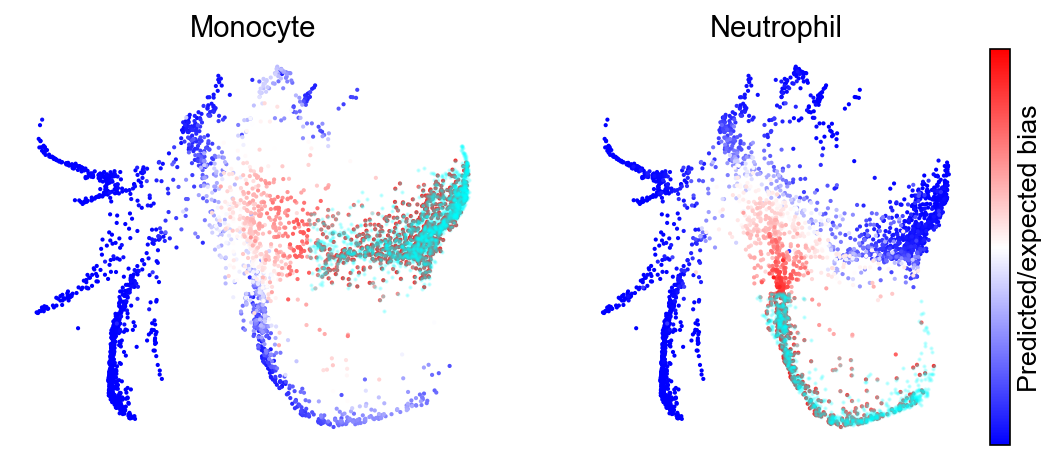

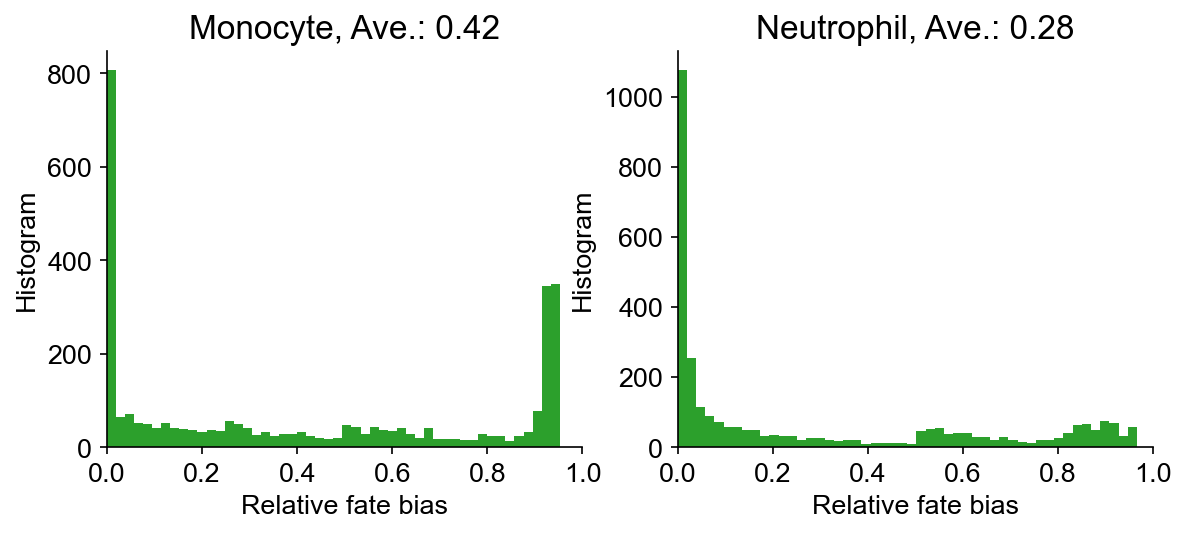

In [17]:
cs.pl.fate_bias_intrinsic(
    adata,
    selected_fates=["Monocyte", "Neutrophil"],
    used_map_name="transition_map",
    plot_time_points=["4"],
    plot_target_state=True,
    map_backwards=True,
)

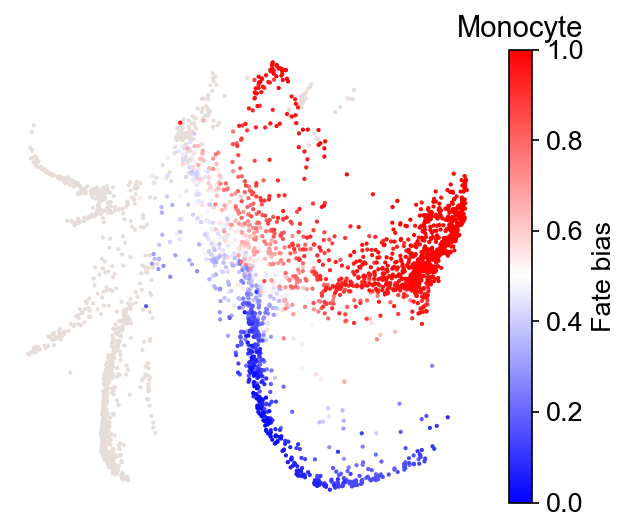

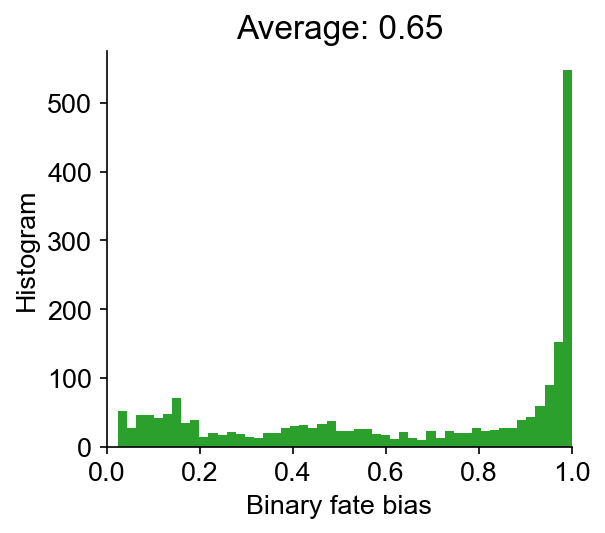

In [18]:
cs.pl.fate_bias_from_binary_competition(
    adata,
    selected_fates=["Monocyte", "Neutrophil"],
    used_map_name="transition_map",
    plot_time_points=["4"],
    plot_target_state=False,
    map_backwards=True,
    sum_fate_prob_thresh=0.1,
)

#### Lineage coupling of the transition map

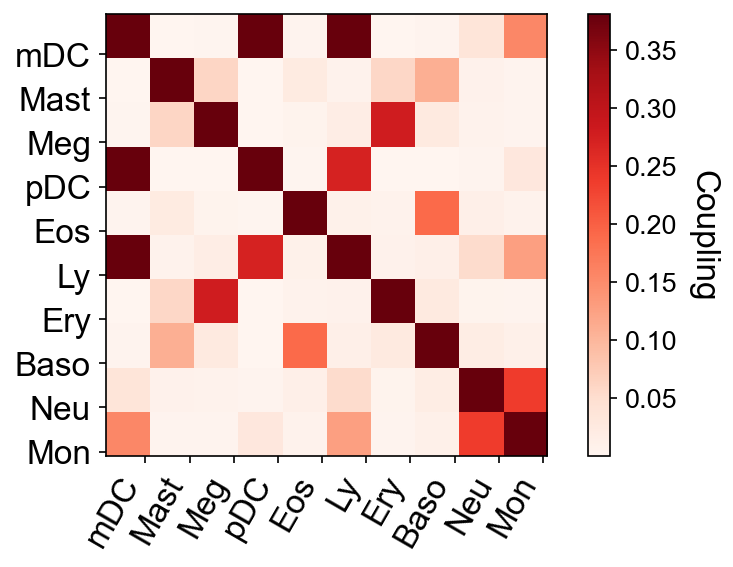

In [19]:
fate_array = [
    "Ccr7_DC",
    "Mast",
    "Meg",
    "pDC",
    "Eos",
    "Lymphoid",
    "Erythroid",
    "Baso",
    "Neutrophil",
    "Monocyte",
]
celltype_names = ["mDC", "Mast", "Meg", "pDC", "Eos", "Ly", "Ery", "Baso", "Neu", "Mon"]
cs.pl.fate_coupling_from_Tmap(
    adata,
    selected_fates=fate_array,
    used_map_name="transition_map",
    rename_selected_fates=celltype_names,
)

#### Dynamic trajectory inference

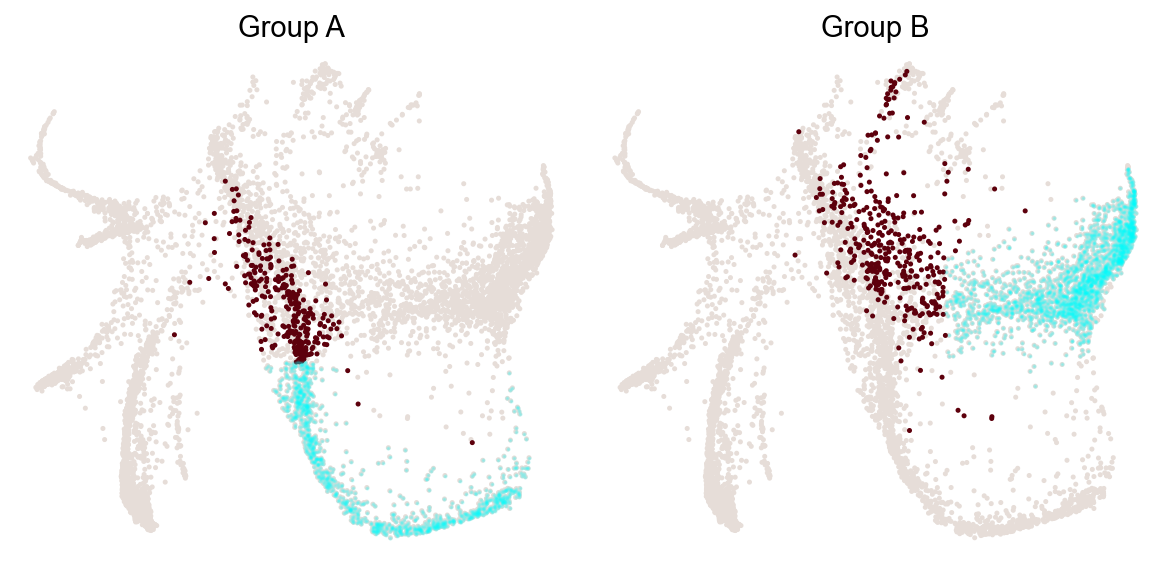

In [20]:
cs.pl.dynamic_trajectory_from_competition_bias(
    adata,
    selected_fates=["Neutrophil", "Monocyte"],
    used_map_name="transition_map",
    map_backwards=True,
    plot_time_points=[],
    bias_threshold=0,
    sum_fate_prob_thresh=0.2,
    avoid_target_states=True,
)

#### Differential genes for two ancestor groups

The selected cell states can be accessed at *adata.obs['DGE_cell_group_A']* and *adata.obs['DGE_cell_group_B']*.
A DGE analysis can be performed below. It is also easy to use other methods for DGE analysis using the selected idx. 

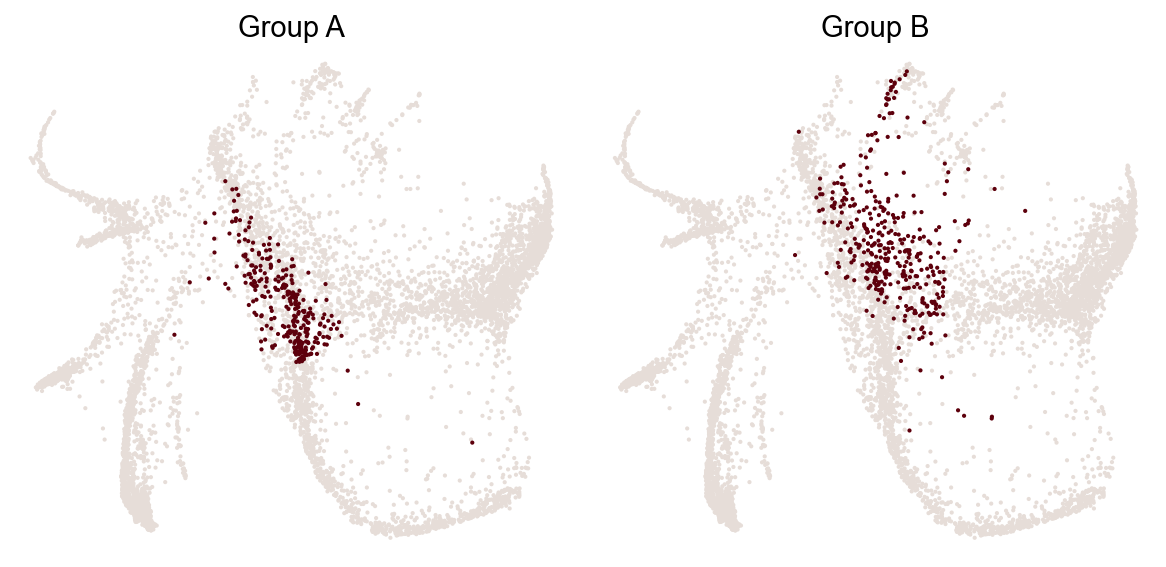

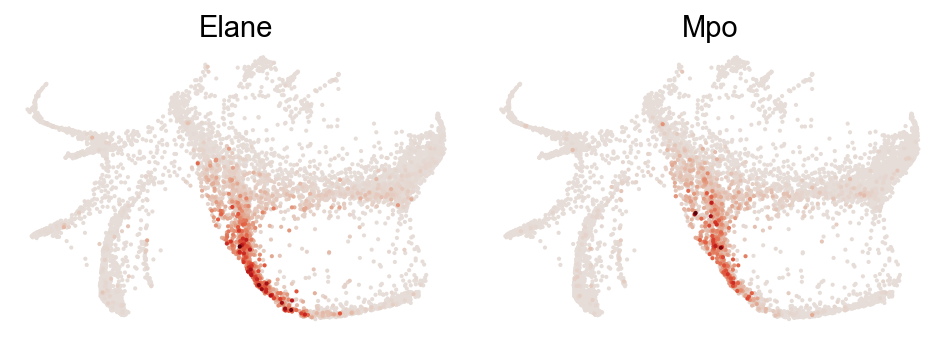

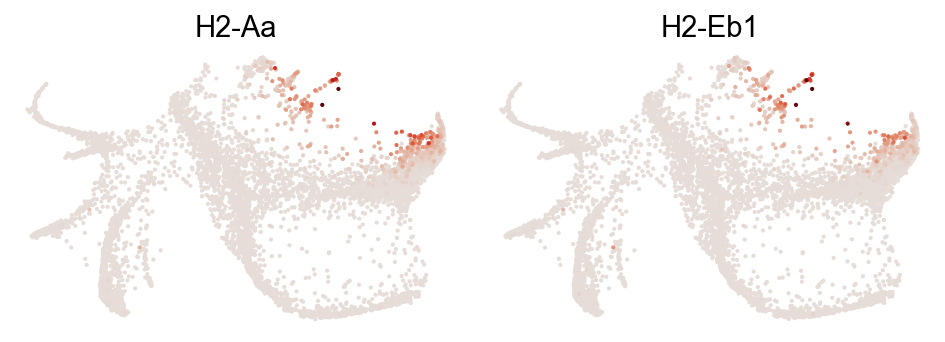

In [21]:
group_A_index = adata.obs["DGE_cell_group_A"]
group_B_index = adata.obs["DGE_cell_group_B"]
dge_gene_A, dge_gene_B = cs.pl.differential_genes(adata, plot_gene_N=2)

#### Gene trend along the dynamic trajectory

The selected states, combined with the target states are stored as dynamic trajectory at adata.uns['dynamic_trajectory'].
We can plot gene trend along this trajectory

/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3.5 x 2.163 in image.
/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: abcde1_fig/LARRY_sp500_ranking1_TwoTimeClone_t*4*6_fate_trajectory_pseutoTime_gene_expression_Neutrophil_True.png


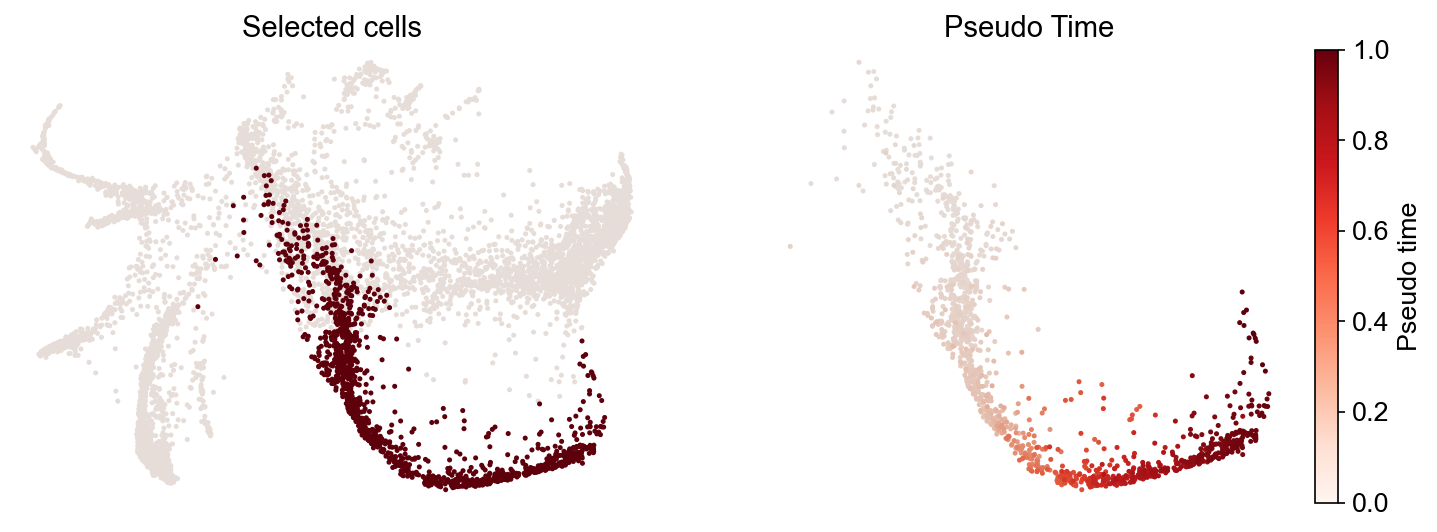

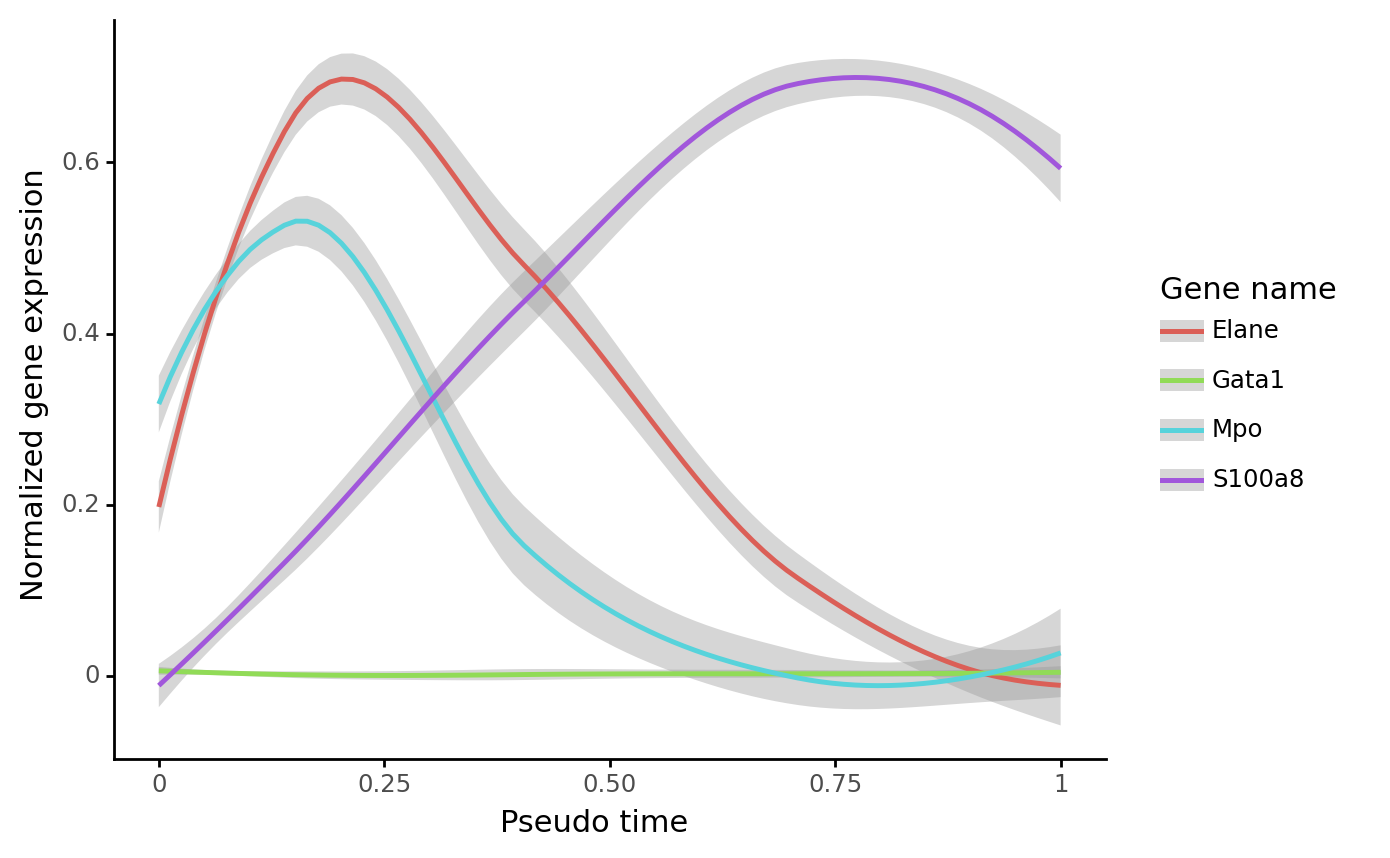

In [22]:
# The results are based on pre-computed dynamic trajectories from a previous step
# better to use the 'intraclone transition map'

gene_name_list = ["Gata1", "Mpo", "Elane", "S100a8"]
selected_fate = "Neutrophil"
adata_selected = cs.pl.gene_expression_dynamics(
    adata,
    selected_fate,
    gene_name_list,
    traj_threshold=0.2,
    map_backwards=True,
    invert_PseudoTime=False,
    include_target_states=True,
    compute_new=True,
    fig_width=3.5,
    gene_exp_percentile=99,
    n_neighbors=8,
    plot_raw_data=False,
    point_size=2,
)

#### Apply other pseudotime methods on the selected cell states

Trying to set attribute `.uns` of view, copying.


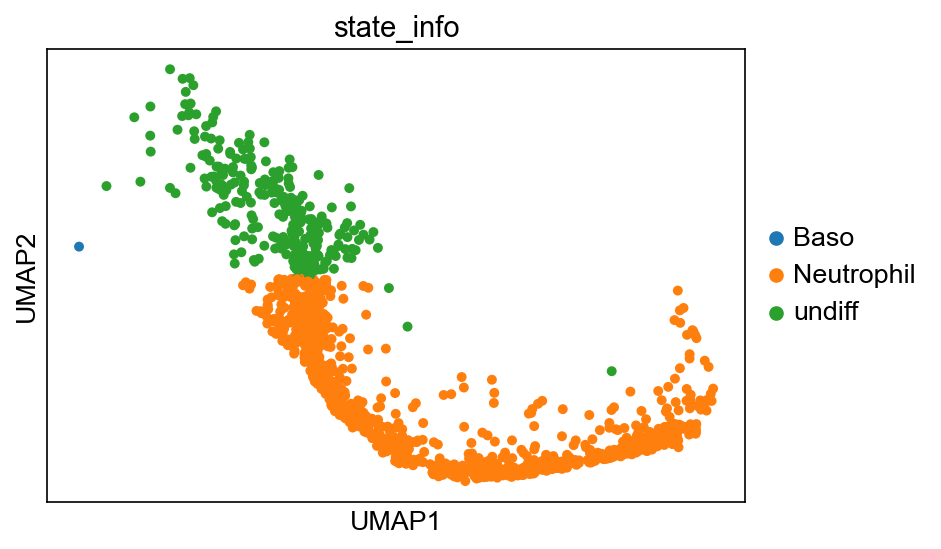

In [23]:
# adata_selected can be used by other analysis package for further analysis
sc.pl.umap(adata_selected, color="state_info")

#### Identify differentially expressed genes

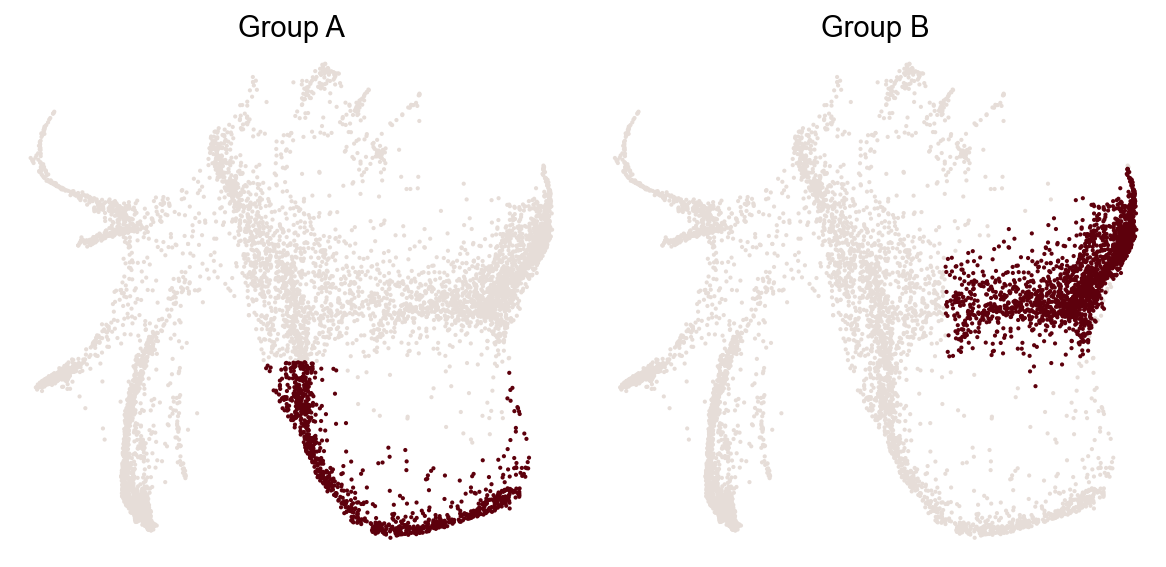

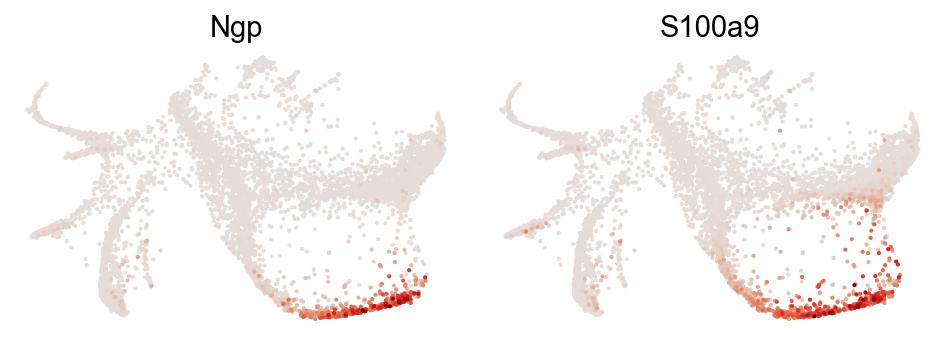

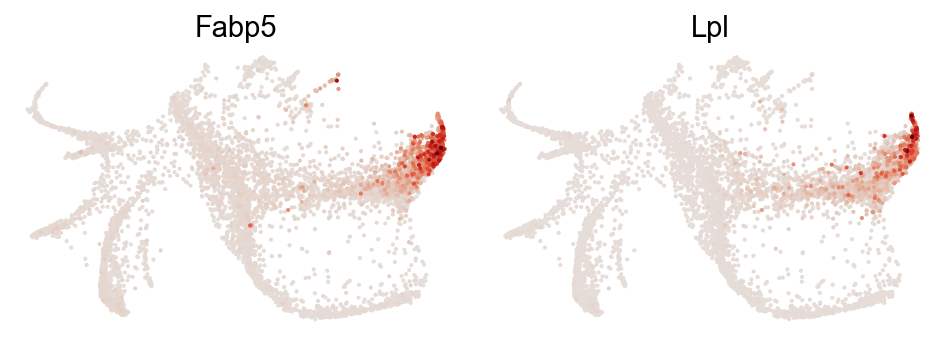

In [24]:
diff_gene_A, diff_gene_B = cs.pl.differential_genes_for_given_fates(
    adata, selected_fates=["Neutrophil", "Monocyte"], gene_N=100, plot_gene_N=2
)

### Transition map from only clonal information
Assume uniform transition within the same clone

This method works when there are only time points and all datasets
Used clone fraction 0.598


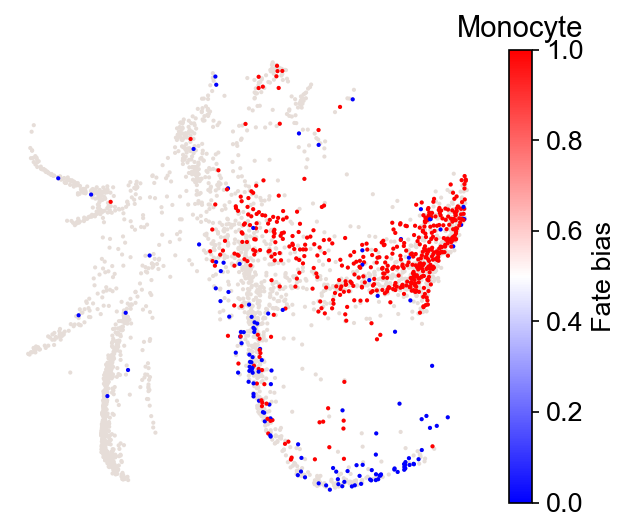

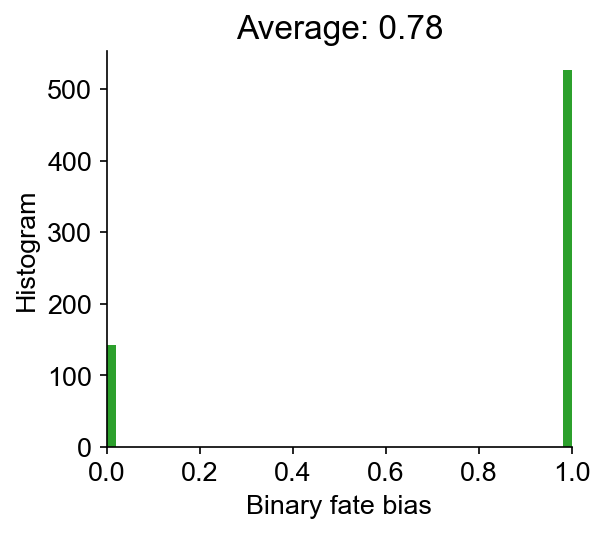

In [25]:
# The Weinreb method: selecting uni-potent clones first; Uniform transition probability within the same clone
cs.tmap.infer_weinreb_Tmap(adata)

cs.pl.fate_bias_from_binary_competition(
    adata,
    selected_fates=["Monocyte", "Neutrophil"],
    used_map_name="weinreb_transition_map",
    plot_time_points=[],
    plot_target_state=False,
    map_backwards=True,
    sum_fate_prob_thresh=0.4,
)

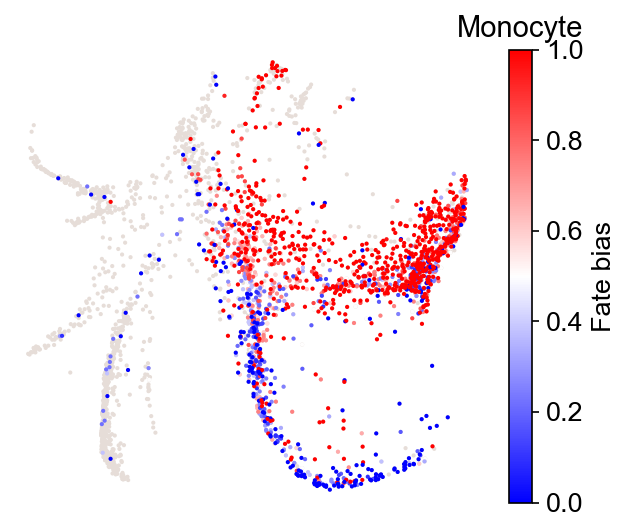

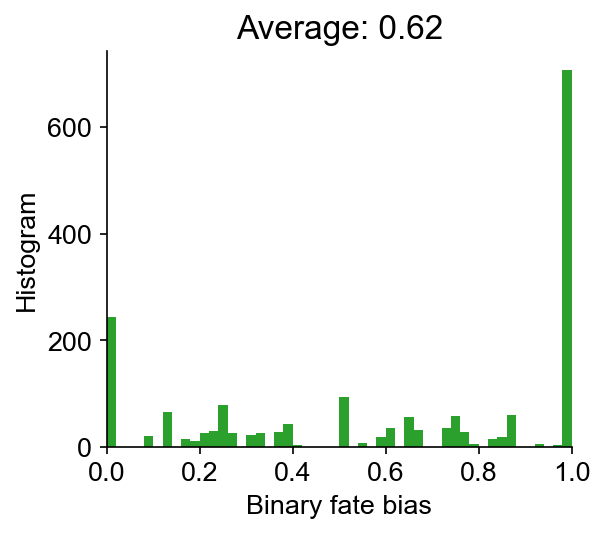

In [26]:
# The naive method: no clone pre-selection. Uniform transition probability within the same clone
cs.tmap.infer_naive_Tmap(adata)

cs.pl.fate_bias_from_binary_competition(
    adata,
    selected_fates=["Monocyte", "Neutrophil"],
    used_map_name="naive_transition_map",
    plot_time_points=[],
    plot_target_state=False,
    map_backwards=True,
    sum_fate_prob_thresh=0.4,
)

## Part II: Infer transition map using clones from all time points

-------Step 1: Select time points---------
--> Clonal cell fraction (day 2-4): 1.0
--> Clonal cell fraction (day 4-6): 1.0
--> Clonal cell fraction (day 4-2): 0.3892466194462331
--> Clonal cell fraction (day 6-4): 1.0
--> Numer of cells that are clonally related -- day 2: 286  and day 4: 1209
--> Numer of cells that are clonally related -- day 4: 3106  and day 6: 4046
Valid clone number 'FOR' post selection 500
Cell number=7438, Clone number=500
-------Step 2: Compute the full Similarity matrix if necessary---------
-------Step 3: Optimize the transition map recursively---------
---------Compute the transition map-----------
Compute similarity matrix: load existing data
--> Time elapsed:  0.09854006767272949
--> Time elapsed:  0.2894721031188965
--> Time elapsed:  0.09804534912109375
--> Time elapsed:  0.29012489318847656
Compute similarity matrix: load existing data
--> Time elapsed:  0.08600926399230957
--> Time elapsed:  0.23519611358642578
--> Time elapsed:  0.08487486839294434
-->

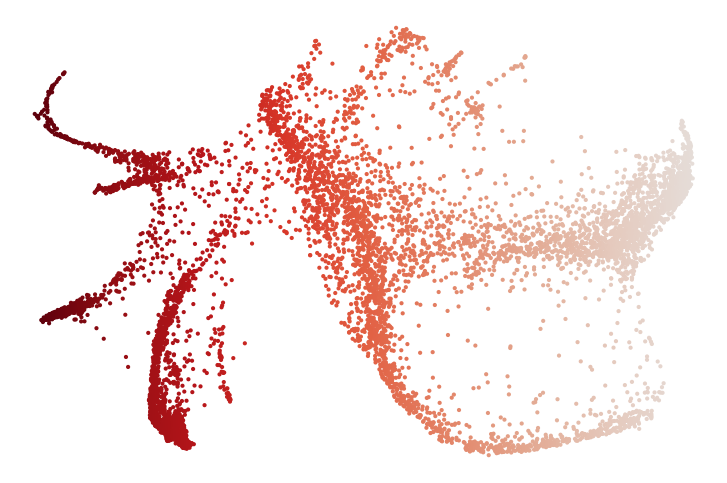

In [27]:
import time

t = time.time()
noise_threshold = 0.2  #
selected_clonal_time_points = ["2", "4", "6"]
adata = cs.tmap.infer_Tmap_from_multitime_clones(
    adata_orig,
    selected_clonal_time_points,
    smooth_array=[20, 15, 10],
    noise_threshold=noise_threshold,
    demulti_threshold=noise_threshold,
    use_full_Smatrix=True,
)
print(f"Used--time: {time.time()-t}")

#### Another way to build dynamic trajectory

From our experience, it is better to use the intra-clone transition map to compute the trajectory 

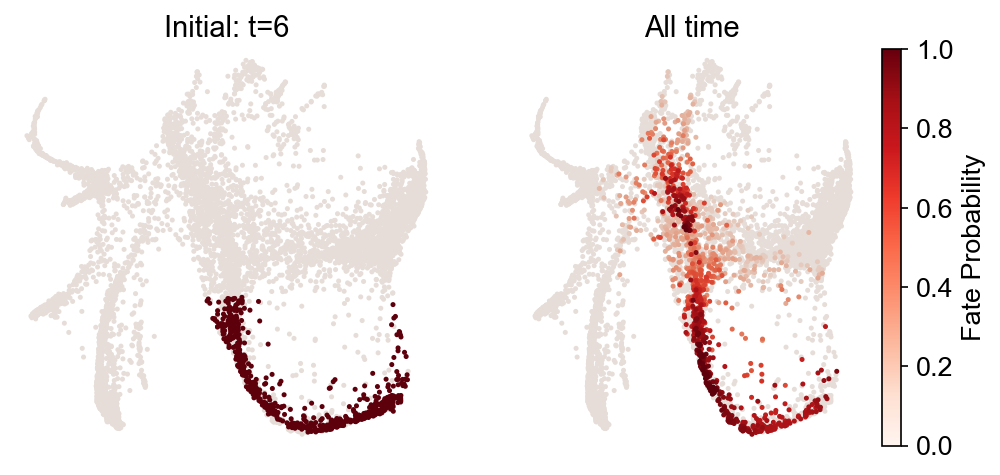

In [28]:
# plot each tiem point separately, use the intra-clone transition map.
cs.pl.dynamic_trajectory_via_iterative_mapping(
    adata,
    selected_fate="Neutrophil",
    used_map_name="transition_map",
    map_backwards=True,
    map_threshold=0.1,
    plot_separately=False,
    apply_time_constaint=True,
    point_size=2,
)

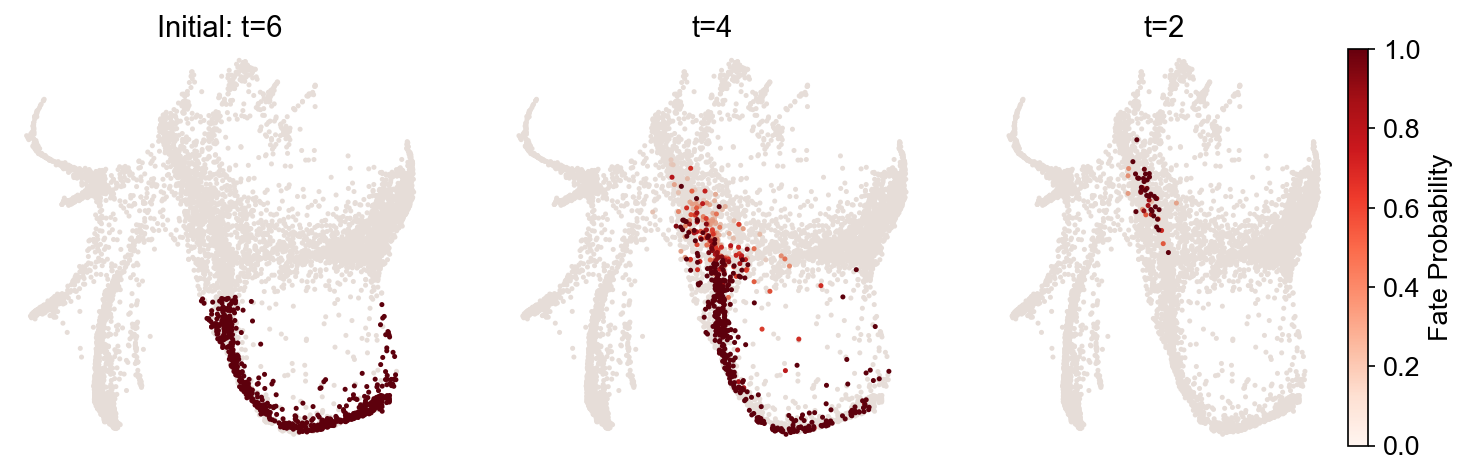

In [29]:
# plot each tiem point separately, use the intra-clone transition map.
cs.pl.dynamic_trajectory_via_iterative_mapping(
    adata,
    selected_fate="Neutrophil",
    used_map_name="intraclone_transition_map",
    map_backwards=True,
    map_threshold=0.1,
    plot_separately=True,
    apply_time_constaint=True,
    point_size=2,
)

#### Gene trend along the trajectory

/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3.5 x 2.163 in image.
/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: abcde1_fig/LARRY_sp500_ranking1_TwoTimeClone_t*2*4*6_fate_trajectory_pseutoTime_gene_expression_Neutrophil_True.png


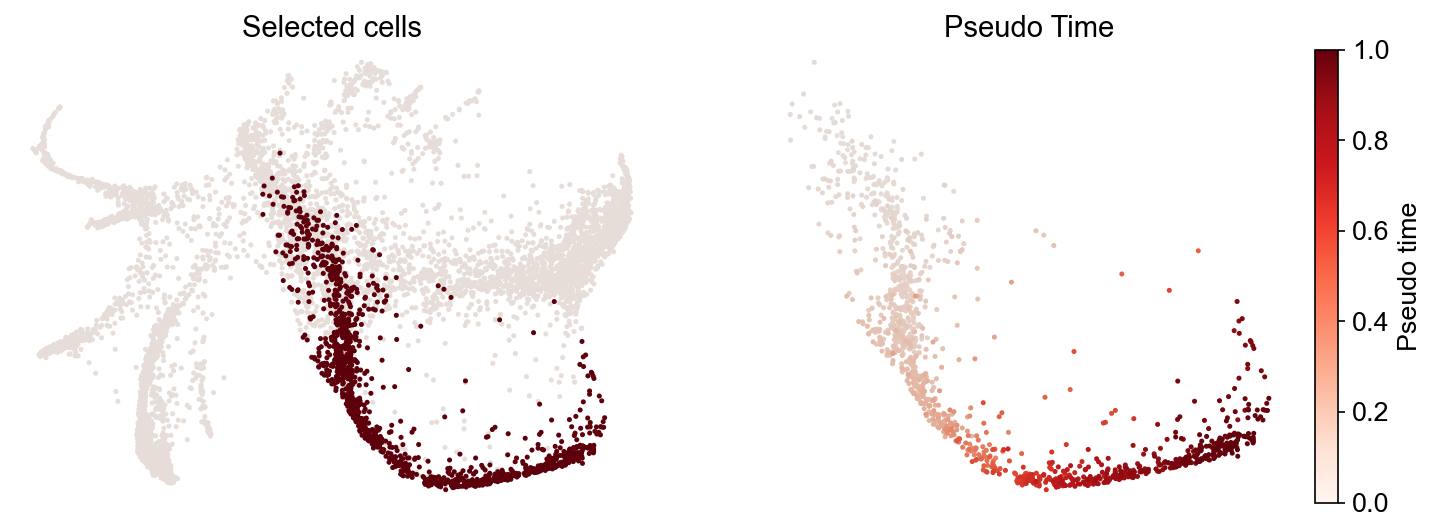

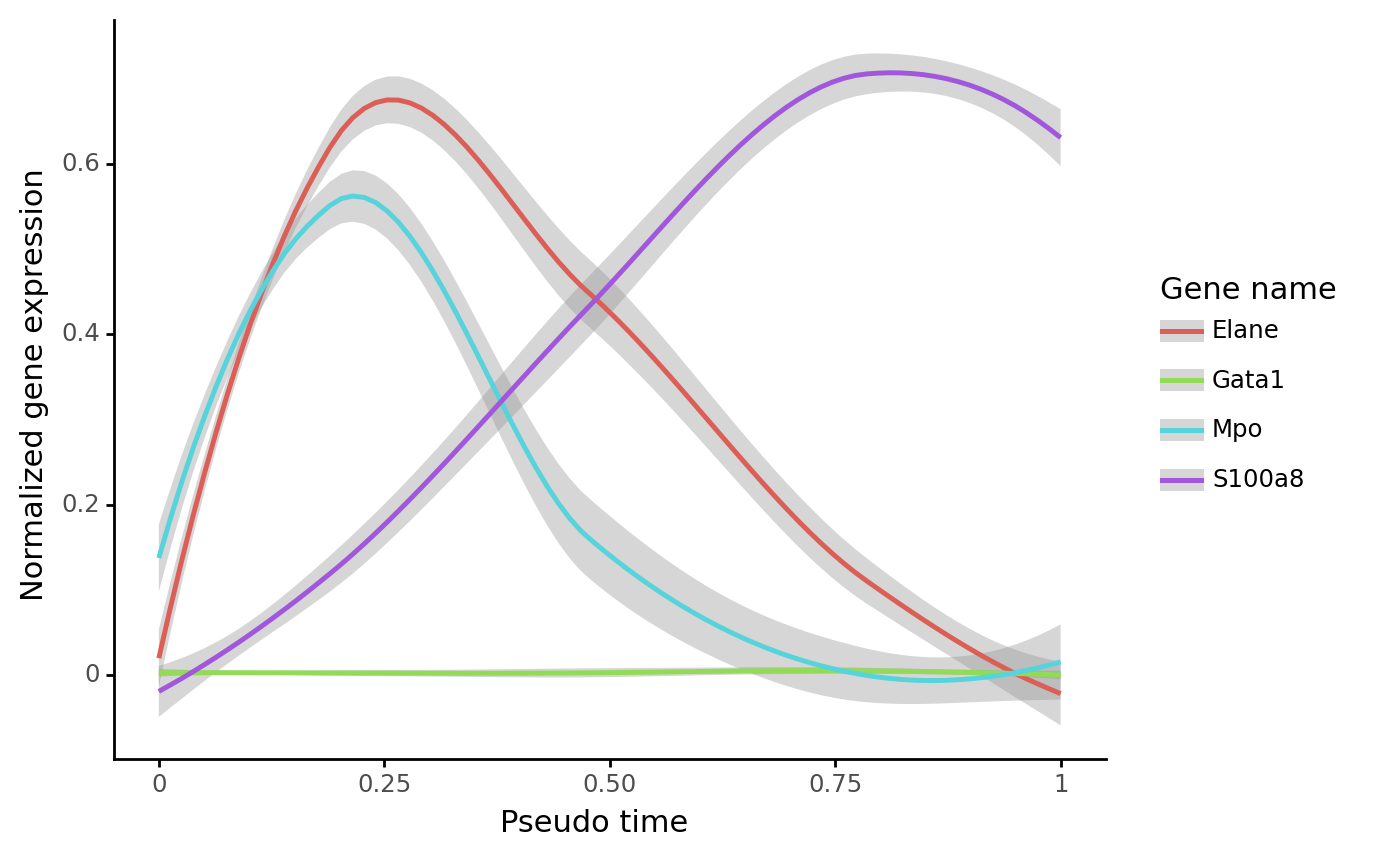

In [30]:
# The results are based on pre-computed dynamic trajectories from a previous step
# better to use the 'intraclone transition map'

gene_name_list = ["Gata1", "Mpo", "Elane", "S100a8"]
selected_fate = "Neutrophil"
adata_selected = cs.pl.gene_expression_dynamics(
    adata,
    selected_fate,
    gene_name_list,
    traj_threshold=0.2,
    map_backwards=True,
    invert_PseudoTime=False,
    include_target_states=True,
    compute_new=True,
    fig_width=3.5,
    gene_exp_percentile=99,
    n_neighbors=8,
    plot_raw_data=False,
    point_size=2,
)

In [31]:
adata.uns["fate_trajectory"]

{'Neutrophil': {'map_backwards': array([1., 0., 0., ..., 1., 1., 1.])}}

## Part III: Infer transition map using only clones from the last time point

*Purpose*: Infer transition map from scRNAseq data where cells at one time point are clonally labeled. After initializing the map by either *OT* method or *HighVar* method, We jointly infer the likely clonal ancestors and the transition map between cell states in these two time points. 

Parameters relevant for cell state selection: *initial_time_points, clonal_time_point, use_full_Smatrix*.

Choose the initialization method, and set the corresponding parameters.

* ‘OT’: tend to be more accurate, but not reliable under batch effect. Key parameters: *OT_epsilon*.

* ‘HighVar’: is robust to batch effect. Related parameters: *HighVar_gene_pctl*.

Parameters relevant for CoSpar itself: *smooth_array, normalization_mode, CoSpar_KNN, noise_threshold, Clone_update_iter_N*.

cs.hf.check_available_choices(adata_orig)

In [32]:
initial_time_points = ["4"]  # ['2','4']
clonal_time_point = "6"
adata = cs.tmap.infer_Tmap_from_one_time_clones(
    adata_orig,
    initial_time_points,
    clonal_time_point,
    Clone_update_iter_N=1,
    initialize_method="OT",
    OT_cost="GED",
    smooth_array=[20, 15, 10],
    noise_threshold=0.2,
    use_full_Smatrix=True,
)

-------------------------------New Start--------------------------------------------------
Current time point: 4
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Finishing computing gene expression distance, used time 5.665994167327881
Load pre-computed custon OT matrix
----------------
Step 2: Jointly optimize the transition map and the initial clonal states!
Joint optimization that consider possibility of clonal overlap: v2
--> original clone shape: (7152, 500)
--> After excluding zero-sized clones at t2: (7152, 500)
Sort clones by size (small to large)
Infer the number of initial cells to extract for each clone in advance
--> Inferring early clonal states: current clone id 0
--> Inferring early clonal states: current clone id 100
--> Inferring early clonal states: current clone id 200
--> Inferring early clonal states: current clone id 300
--> Inferring early clonal states: current clone id 400
---------Compute th

#### Plot fate map

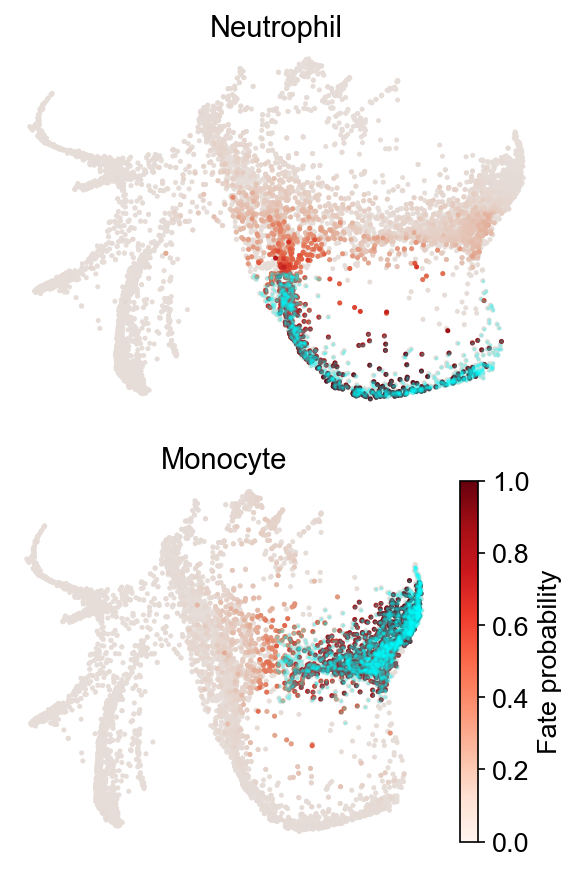

In [34]:
cs.pl.fate_map(
    adata,
    selected_fates=["Neutrophil", "Monocyte"],
    used_map_name="transition_map",
    map_backwards=True,
    plot_target_state=True,
)

#### Plot binary fate choice

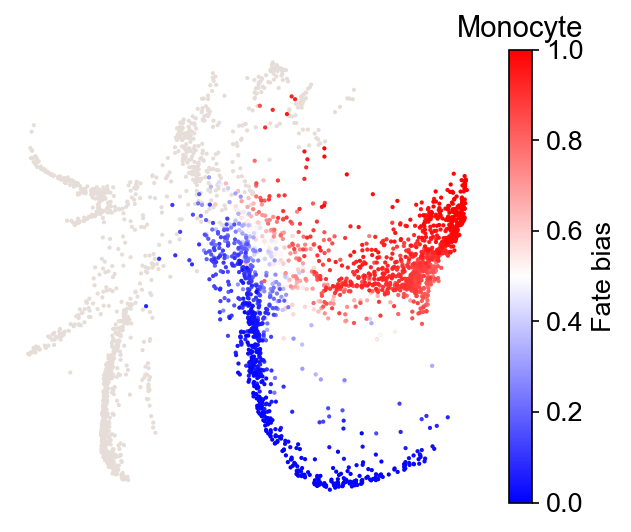

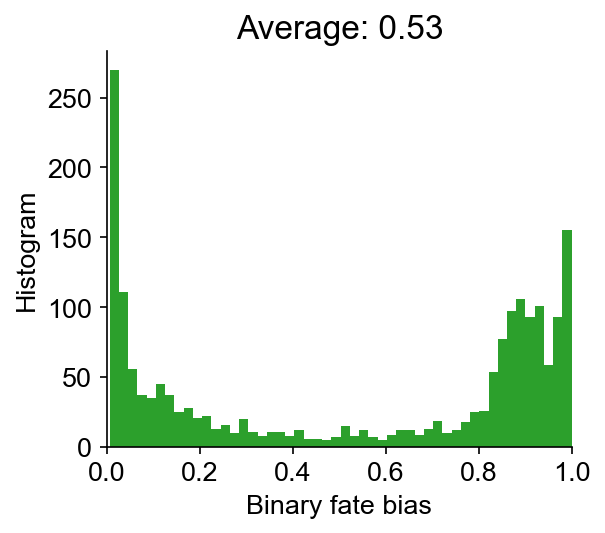

In [35]:
# Tmap from gap method, using gene expression distance
cs.pl.fate_bias_from_binary_competition(
    adata,
    selected_fates=["Monocyte", "Neutrophil"],
    used_map_name="transition_map",
    plot_time_points=["4"],
    plot_target_state=False,
    map_backwards=True,
    sum_fate_prob_thresh=0.1,
)

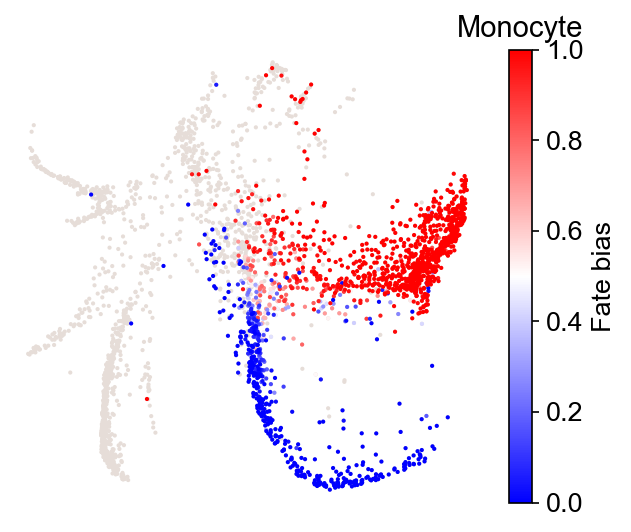

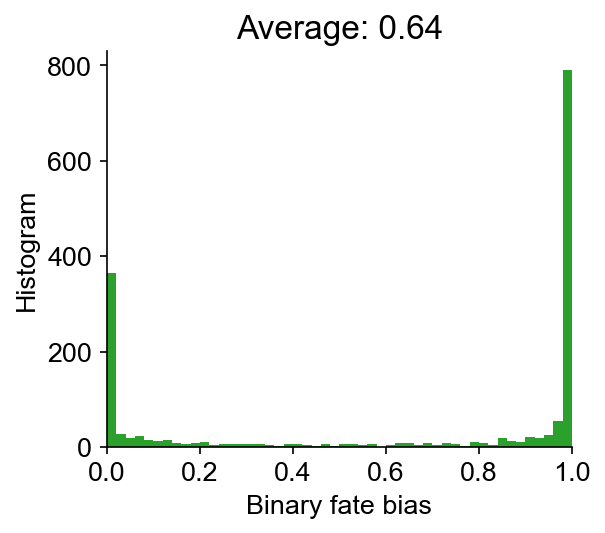

In [36]:
# Tmap from gap method, using gene expression distance
cs.pl.fate_bias_from_binary_competition(
    adata,
    selected_fates=["Monocyte", "Neutrophil"],
    used_map_name="OT_transition_map",
    plot_time_points=[],
    plot_target_state=False,
    map_backwards=True,
    sum_fate_prob_thresh=0.1,
)

#### Lineage coupling of the transition map

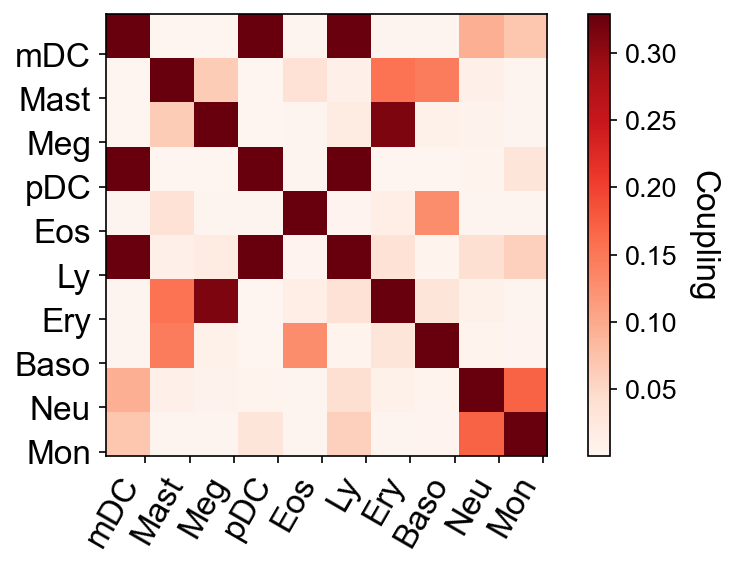

In [37]:
fate_array = [
    "Ccr7_DC",
    "Mast",
    "Meg",
    "pDC",
    "Eos",
    "Lymphoid",
    "Erythroid",
    "Baso",
    "Neutrophil",
    "Monocyte",
]
celltype_names = ["mDC", "Mast", "Meg", "pDC", "Eos", "Ly", "Ery", "Baso", "Neu", "Mon"]
cs.pl.fate_coupling_from_Tmap(
    adata,
    selected_fates=fate_array,
    used_map_name="transition_map",
    rename_selected_fates=celltype_names,
)

#### Dynamic trajectory inference

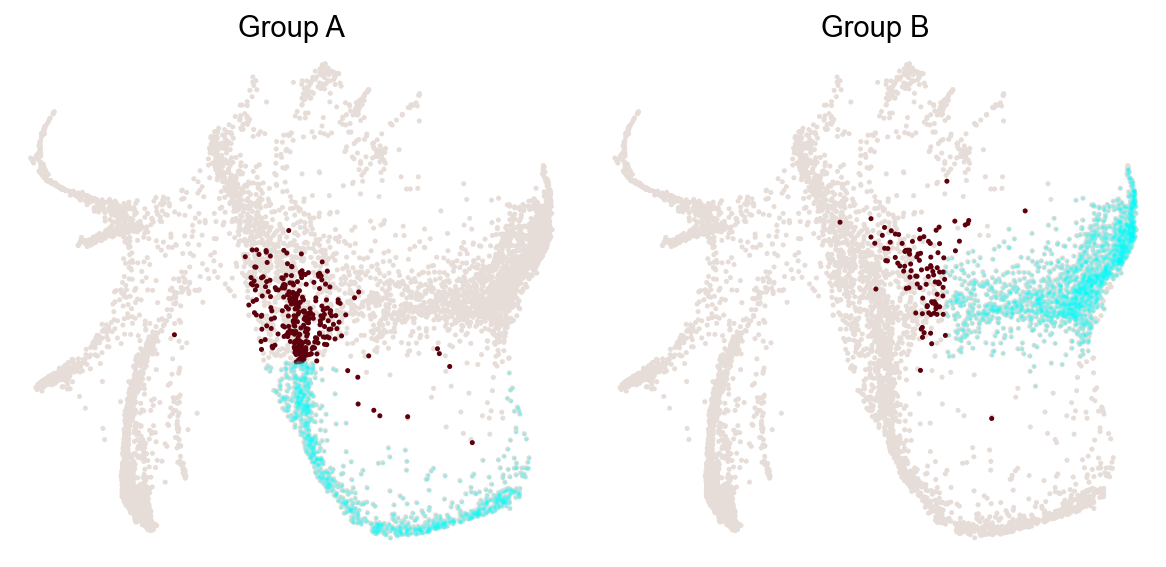

In [38]:
cs.pl.dynamic_trajectory_from_competition_bias(
    adata,
    selected_fates=["Neutrophil", "Monocyte"],
    used_map_name="transition_map",
    map_backwards=True,
    plot_time_points=[],
    bias_threshold=0,
    sum_fate_prob_thresh=0.2,
    avoid_target_states=True,
)

The results are saved in adata, and can be used to perform DGE analysis or plot gene trends, as shown above. 